In [1]:
library(igraph)
library(magrittr)
library(tidygraph)
library(tidyverse)
library(cowplot)
library(ggrepel)

theme_set(theme_cowplot())
results <- '../results/'
fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod','All')
palette_yn <- c('No' = 'gray80', 'Yes' = 'firebrick')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        masks tidygraph::groups(), igr

# SF1

In [2]:
evs <- read_tsv(paste0(results,'conventional_gwas/genesis_2019.eigenvec'))

options(repr.plot.width=7.4, repr.plot.height=7.5)
pc1_2 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC2, PC1, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc3_4 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC4, PC3, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc5_6 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC6, PC5, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc7_8 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC8, PC7, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

sf1 <- plot_grid(pc1_2, pc3_4, pc5_6, pc7_8, labels = c('A','B','C','D'))

Parsed with column specification:
cols(
  .default = col_double(),
  IID = col_character()
)
See spec(...) for full column specifications.


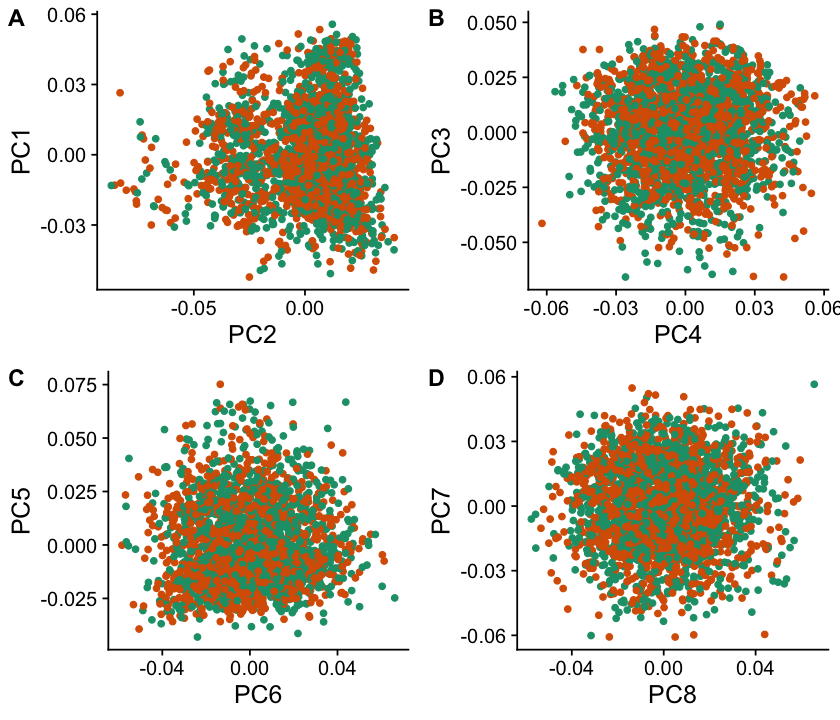

In [3]:
options(repr.plot.width=7, repr.plot.height=6)
sf1
ggsave('figures/sfigure_1.pdf', sf1, width=7, height=6)

# SF2

In [4]:
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

bms <- list(dmgwas, heinz, lean, scones_gs, scones_gm, scones_gi, sigmod)
sf2 <- lapply(bms, function(x) 
       lapply(bms, function(x,y) 
           length(intersect(x,y))/length(union(x,y)), x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, jaccard, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           jaccard = round(as.numeric(jaccard), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = jaccard, label = jaccard)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = 0.5))

Warning message:
“Removed 1 rows containing missing values (geom_text).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

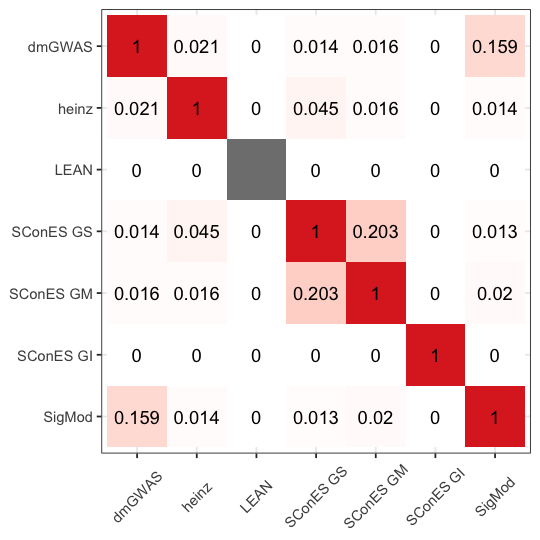

In [5]:
options(repr.plot.width=4.5, repr.plot.height=4.5)
sf2
ggsave('figures/sfigure_2.pdf', sf2, width=4.5, height=4.5)

# SF3

In [6]:
hgnc <- read_tsv(paste0(results,'preprocessing/non_alt_loci_set.txt'), 
                 col_types = cols(.default = "c")) %>%
    select(symbol, ensembl_gene_id)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
gene_types <- read_tsv(paste0(results,'bad_genes/gencode.v31.annotation.gff3'), comment = '#', 
                       col_names = FALSE, col_types = cols(.default = "c")) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    inner_join(hgnc, by = "ensembl_gene_id")

genes_icogs <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')$gene %>% unique
genes_hint <- as_tibble(ppi)$name

sf3 <- filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 45 rows [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, ...].”

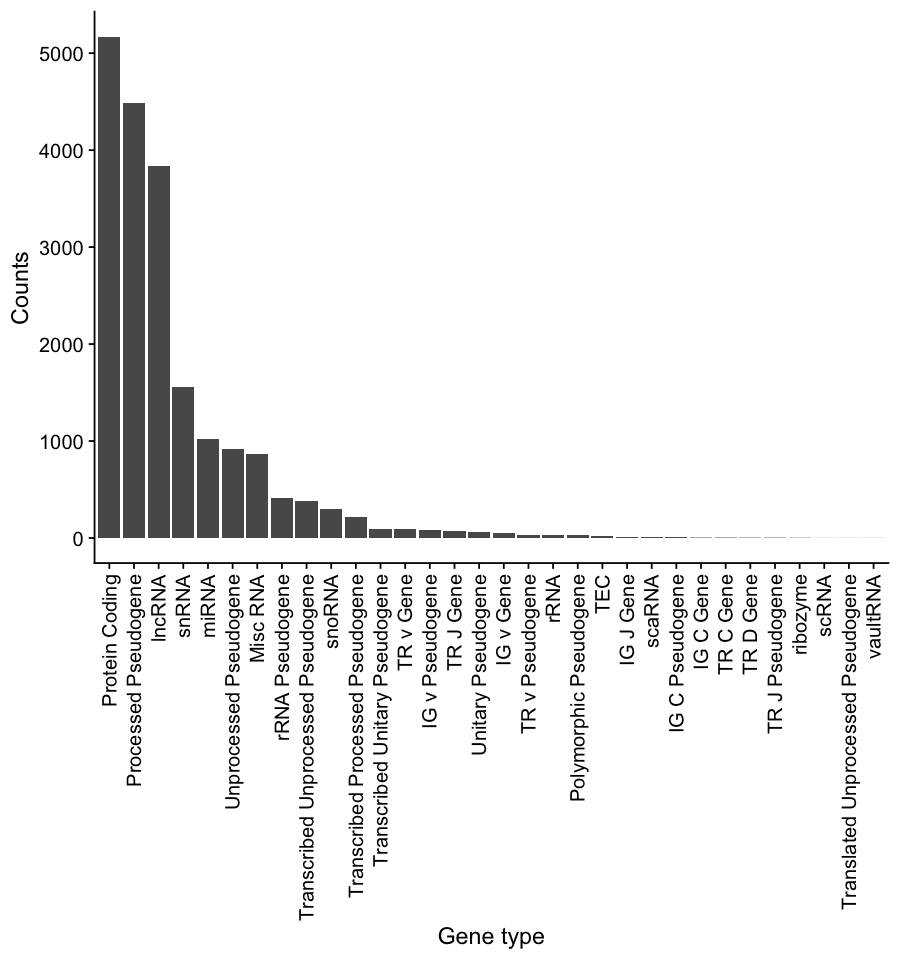

In [7]:
options(repr.plot.width=7.5, repr.plot.height=8)
sf3
ggsave('figures/sfigure_3.pdf', sf3, width=7, height=6)

# SF4: BCAC comparison

In [8]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd'), 
                    read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd'), 
           by = c("Chr", "Gene", "Start", "Stop"),
           suffix = c('_bcac', '_genesis')) %>%
    filter(Gene %in% genes_in_ppi)

plot_selected_genes <- function(genes, selected) {
    
    p_bonf_genes = .05 / nrow(genes)
    
    genes %>%
        mutate(sign_genesis = ifelse(`Top-0.1-pvalue_genesis` < p_bonf_genes, 'Yes', 'No'),
               sign_bcac = ifelse(`Top-0.1-pvalue_bcac` < p_bonf_genes, 'Yes', 'No') ) %>%
        mutate(selected = ifelse(Gene %in% selected, 'Selected', 'Unselected')) %>%
        select(selected, sign_genesis, sign_bcac) %>%
        gather(where, sign, -selected) %>%
        mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
        ggplot(aes(x = selected, fill = sign)) +
            geom_bar(position = 'fill') +
            labs(y = 'Fraction', x = 'Genes') +
            theme_bw() +
            scale_fill_manual(values = palette_yn) +
            facet_wrap(where ~ .) +
            theme(legend.position = 'none',
                  axis.text = element_text(size = 8),
                  axis.title = element_text(size = 10),
                  strip.text = element_text(size = 10),
                  strip.background = element_rect(fill="white", color = 'white'))
    
}

consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllli')$gene
consensus_bcac <- plot_selected_genes(genes, consensus)

sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
sigmod_bcac <- plot_selected_genes(genes, sigmod)

dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
dmgwas_bcac <- plot_selected_genes(genes, dmgwas)

heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
heinz_bcac <- plot_selected_genes(genes, heinz)

# scones comparison
snps <- inner_join(
           read_tsv(paste0(results,'bcac/icogs_bcac_public_results_euro.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No') ) %>%
    mutate(selected = ifelse(SNP %in% selected, 'Selected', 'Unselected')) %>%
    select(selected, sign_genesis, sign_bcac) %>%
    gather(where, sign, -selected) %>%
    mutate(where = ifelse(where == 'sign_genesis', 'GENESIS', 'BCAC')) %>%
    ggplot(aes(x = selected, fill = sign)) +
        geom_bar(position = 'fill') +
        labs(fill = 'Dataset significant', y = 'Fraction', x = 'SNPs') +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        facet_wrap(where ~ .) +
        theme(legend.position = 'bottom',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="white", color = 'white'))
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_bcac <- plot_selected_snps(snps, gs)

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_bcac <- plot_selected_snps(snps, gm)
legend <- cowplot::get_legend(gm_bcac)

gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi_bcac <- plot_selected_snps(snps, gi)

sf4_no_leg <- plot_grid(consensus_bcac, dmgwas_bcac, heinz_bcac, 
                        gs_bcac + theme(legend.position="none"), 
                        gm_bcac + theme(legend.position="none"), 
                        gi_bcac + theme(legend.position="none"), 
                        sigmod_bcac, ncol = 2, label_size = 10, hjust = 0,
                        labels = c('Consensus', 'dmGWAS', 'heinz', 'SConES GS', 
                                   'SConES GM', 'SConES GI', 'SigMod'))
sf4 <- plot_grid(sf4_no_leg, legend, nrow = 2, rel_heights = c(12,1))

Parsed with column specification:
cols(
  Uniprot_A = col_character(),
  Uniprot_B = col_character(),
  Gene_A = col_character(),
  Gene_B = col_character(),
  ORF_A = col_character(),
  ORF_B = col_character(),
  Alias_A = col_character(),
  Alias_B = col_character(),
  `pmid:method:quality` = col_character(),
  id = col_double(),
  `Official Symbol Interactor A` = col_character(),
  `Official Symbol Interactor B` = col_character()
)


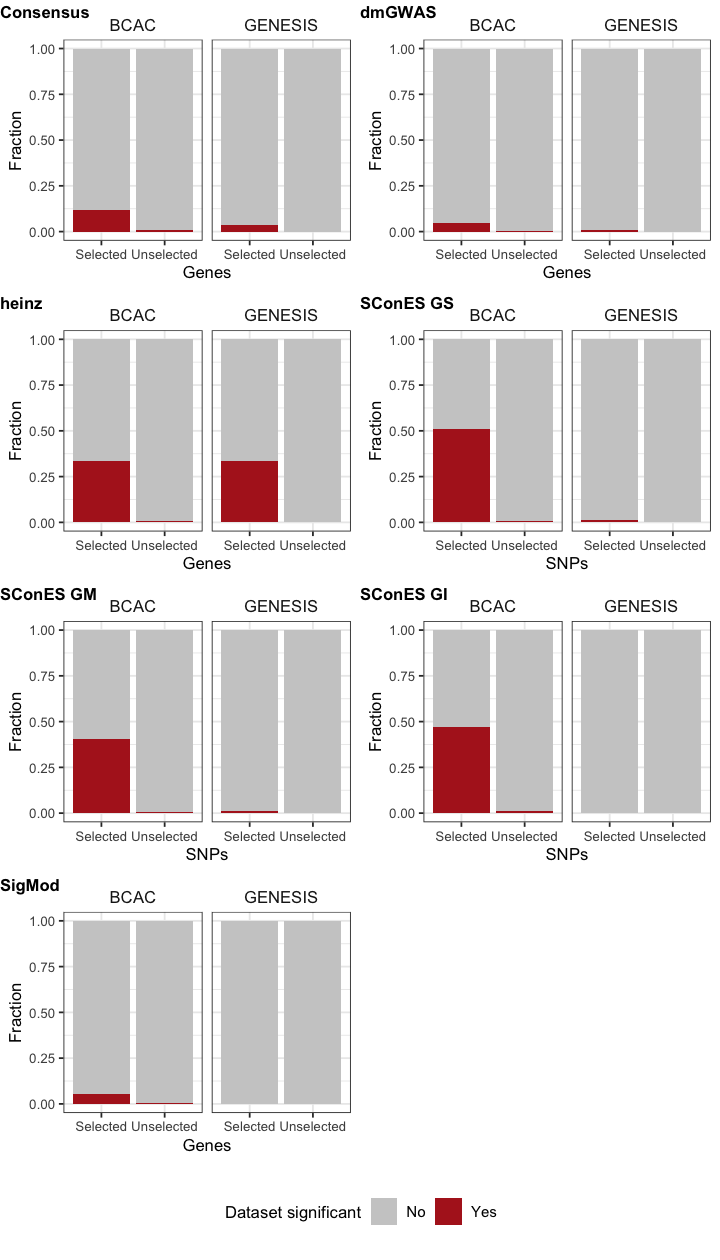

In [9]:
options(repr.plot.width=6, repr.plot.height=10.5)
sf4
ggsave('figures/sfigure_4.pdf', sf4, width=6, height=10.5)

# SF5: HT vs. (HT + LC)

In [10]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GS' = '#fb6a4a',
                    'SConES GM' = '#cb181d', 'SConES GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black')

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method))
stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)))
time_ht <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses','vegas')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)),
           time_s = parse_deltatime(realtime),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'))

pred_lc <- read_tsv(paste0(results,'lc_ht_network/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method))
stab_lc <- read_tsv(paste0(results,'lc_ht_network/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)))
time_lc <- read_tsv(paste0(results,'lc_ht_network/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses','vegas')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)),
           time_s = parse_deltatime(realtime),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'))

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [97, 99].”Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [87, 89].”

In [11]:
sel_act <- inner_join(group_by(pred_lc, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       group_by(pred_ht, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       by = 'method', suffix = c('_lc','_ht')) %>%
    group_by(method) %>%
    filter(method != 'All') %>%
    summarize(delta_selected = n_selected_lc/n_selected_ht,
              delta_active = n_active_lc/n_active_ht) %>%
    ggplot(aes(x = delta_selected, y = delta_active, 
               label = method, color = method)) +
        geom_point() +
        geom_hline(yintercept = 1, color = 'gray') +
        geom_vline(xintercept = 1, color = 'gray') +
        geom_text_repel(size = 3) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Ratio selected', y = 'Ratio active') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

sens_spec <- inner_join(group_by(pred_lc, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        group_by(pred_ht, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    group_by(method) %>%
    summarize(delta_sensitivity = sensitivity_ht - sensitivity_lc,
              delta_specificity = specificity_ht - specificity_lc) %>%
    ggplot(aes(x = delta_sensitivity, y = delta_specificity, 
               label = method, color = method)) +
        geom_point() +
        geom_hline(yintercept = 0, color = 'gray') +
        geom_vline(xintercept = 0, color = 'gray') +
        geom_text_repel(size = 3) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Delta sensitivity', y = 'Delta specificity') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

jacc <- inner_join(group_by(stab_lc, method) %>%
                            summarize(jaccard = mean(jaccard)),
                        group_by(stab_ht, method) %>%
                            summarize(jaccard = mean(jaccard)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    group_by(method) %>%
    summarize(delta_jaccard = jaccard_ht - jaccard_lc) %>%
    ggplot(aes(x = delta_jaccard, y = method, color = method)) +
        geom_point() +
        geom_vline(xintercept = 0, color = 'gray') +
        labs(x = 'Delta Jaccard') +
        scale_color_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11))

time <- inner_join(group_by(time_lc, method, type) %>%
                       summarize(time_s = mean(time_s)),
                   group_by(time_ht, method, type) %>%
                       summarize(time_s = mean(time_s)),
                   by = c('method','type'), suffix = c('_lc','_ht')) %>%
    group_by(method, type) %>%
    summarize(ratio_time_s = time_s_lc / time_s_ht) %>%
    ggplot(aes(x = ratio_time_s, y = method, color = method)) +
        geom_point() +
        geom_vline(xintercept = 1, color = 'gray') +
        labs(x = 'Delta time (s)') +
        scale_color_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        facet_grid(type ~ ., scales = 'free', space = 'free')

sf5 <- plot_grid(sel_act, sens_spec, jacc, time, nrow = 2, labels = c('A','B','C','D'))

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

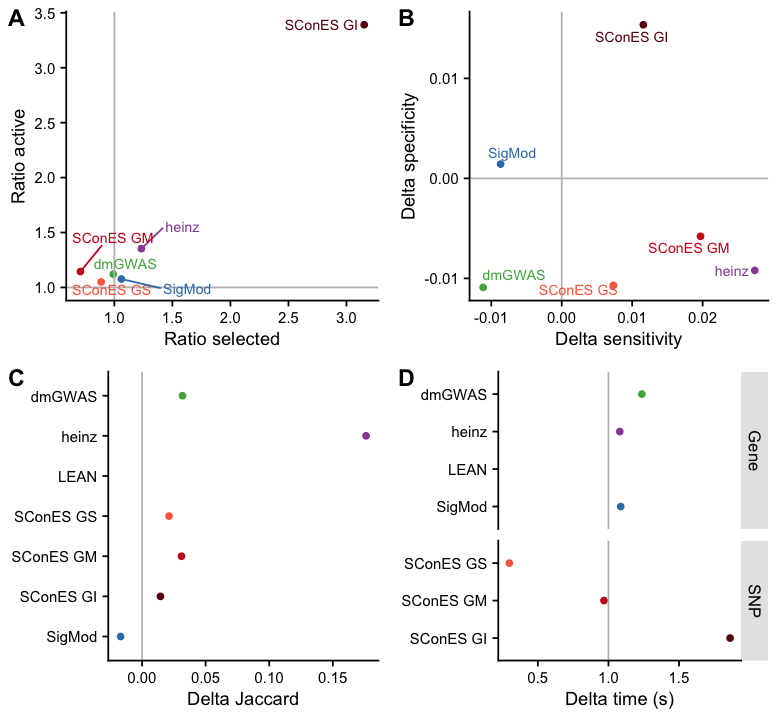

In [12]:
options(repr.plot.width=6.5, repr.plot.height=6)
sf5
ggsave('figures/sfigure_5.pdf', sf5, width=6.5, height=6)

# SF6: consensus network

In [13]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllli')
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweeness = centrality_betweenness())
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

bwness_box <- ppi %>%
    mutate(in_consensus = ifelse(name %in% consensus$gene, 'Yes', 'No'),
           cancer_gene = name %in% known_brca_genes) %>%
    as_tibble %>%
    ggplot(aes(x = in_consensus, y = betweeness, fill = cancer_gene)) +
        geom_boxplot(outlier.colour = NA) +
        scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50')) +
        scale_y_continuous(limits = c(0, 1e+5)) +
        labs(x = 'In consensus network', y = 'Betweeness centrality') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title = element_text(size = 11))

num_methods_assoc <- ggplot(consensus, aes(x = as.character(num_methods), y = -log10(p))) +
    geom_boxplot() +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50')) +
    labs(x = 'Number of methods', y = bquote('-log'[10]~'(P-value)')) +
    theme(legend.position = 'none',
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11))

hist_num_methods <- arrange(consensus, num_methods) %>%
    mutate(gene = factor(gene, levels = gene)) %>%
    ggplot(aes(x = gene, y = num_methods, 
               fill = ifelse(known, 'Yes','No'))) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('Yes' = '#ff96a7', 'No' = 'gray50')) +
        labs(x = 'Gene', y = 'Number of methods', fill = 'Familial BRCA gene') +
        theme(legend.position = 'none',
              axis.text = element_text(size = 7),
              axis.title = element_text(size = 11),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 11))

centrality_assoc <- ggplot(consensus, aes(y = -log10(p), x = log10(betweenness))) +
    geom_point(aes(color = known)) +
    geom_smooth(method = "glm") +
    labs(x = bquote('log'[10]~'(Betweenness centrality)'), 
         y = bquote('-log'[10]~'(P-value)')) +
    theme(legend.position = 'none',
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11)) +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50'))

legend <- get_legend(hist_num_methods + theme(legend.position = 'bottom',
                                              legend.justification = 'center'))

sf6 <- plot_grid(plot_grid(hist_num_methods,
                           plot_grid(num_methods_assoc, bwness_box, centrality_assoc,
                                     labels = c('B','C','D'), nrow = 3),
                           ncol = 2, labels = 'A'),
                 legend, nrow = 2, rel_heights = c(10,1))

Warning message:
“Removed 409 rows containing non-finite values (stat_boxplot).”

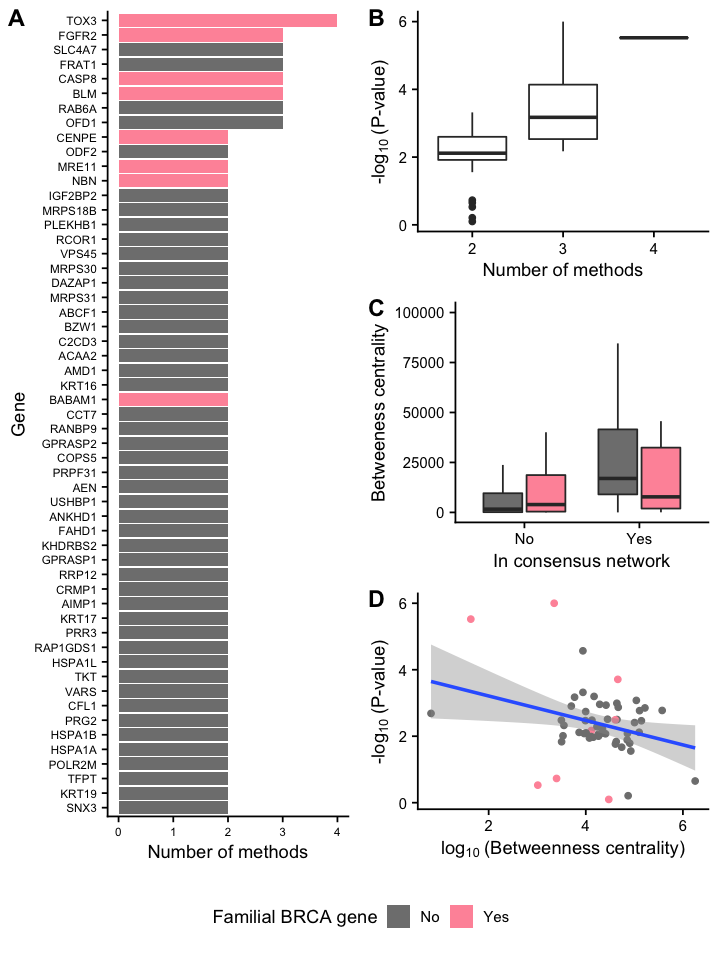

In [14]:
options(repr.plot.width=6, repr.plot.height=8)
sf6
ggsave('figures/sfigure_6.pdf', sf6, width=6, height=8)